# Protein folding problems using HUBO Solver

In 2012, Alejandro et al. solved the protein folding problem using a quantum annealing machine (D-wave) [1].

Here, the protein folding problem is to predict the 3D structure of a protein from its 1D information in the form of an amino acid sequence.
Proteins are characterized by their amino acid sequences, and it is known that each amino acid sequence corresponds to a unique 3D structure.
Since a protein can function as a biopolymer only when it has a unique 3D structure, predicting that from its amino acid sequence information is critical.
However, the causal relationship between the amino acid sequence and the 3D protein structure is still not well understood and is a very difficult problem.

In this note, we will solve the protein folding problem using OpenJij's HUBO solver and compare the results with the paper [1].

## Overview, Hydrophobic-Polar (HP) model, and Miyazawa-Jernigan (MJ) model

### Overview
The 3D structure of a protein is determined by viewing the protein structure as a simple lattice folding model, encoding it in the HUBO format, and solving it.
There are several types of lattice folding models, and two representative models, the HP model and the MJ model, are introduced below.
In the paper [1], the MJ model is used as the problem is regarded as a 2D structural problem.

### HP model 
A protein has a stable 3D structure consisting of polypeptides folded from tens to hundreds of amino acid sequences.
It is difficult to treat the 3D structure of a polypeptide as it is, even with a supercomputer, because it is computationally expensive.
This is because we need to take into account various forces such as hydrogen bonding, electrostatic interactions, van der Waals forces, hydrophobic interactions, etc to calculate the energy of a protein molecule.
However, even a very simple model dealing only with hydrophobic interactions can explain this to a certain extent.

Lau and Dill proposed the HP model [2], a lattice model that considers only hydrophobic interactions.
This model classifies amino acids into only two types, hydrophobic (H: hydrophobic) and hydrophilic (P: polar), and represents the amino acid sequence as an H and P sequence.
This model states that the energy is lowered when the H monomers are in the nearest neighbor lattice to each other.

Reference

- https://repository.kulib.kyoto-u.ac.jp/dspace/bitstream/2433/96792/1/KJ00004709268.pdf
- http://www.iba.t.u-tokyo.ac.jp/iba/AI/HP.pdf


### MJ Model
In the HP model, amino acids are simplified and classified into only two types: hydrophobic and hydrophilic. In other words, it does not take into account the differences in the magnitude of interactions between the amino acids.
We could consider this difference to build a more accurate model, and this is the MJ model.

The MJ model collects a large number of proteins with known 3D structures, counts the number of amino acid pairs that are close to each other among them, and expresses the statistical information as interaction energies between amino acids.
If the number of amino acid pairs in a 3D structure group is large, the absolute value of the interaction energy becomes large.
This interaction energy expresses the tendency of amino acid pairs to form more or less easily.

The paper [1] uses the values reported in Table 3 of the reference paper [3].

## Solution Overview
This section describes how to construct the model addressed in the paper [1].
The amino acid sequence used in this study is a 6-amino acid sequence: Proline-Serine-Valine-Lysine-Methionine-Alanine (P-S-V-K-M-A).
Note that the order of the amino acids P-S-V-K-M-A is fixed.
We consider the problem of folding these amino acid sequences on a 2D lattice.
However, it is difficult to process all the amino acid sequences at once, even though there are only six.
Therefore, we build the model by considering some already folded patterns to start with.
In the following, we will discuss scheme 3 from the paper [1] as a simple example.

In this tutorial, we will explain the detailed solution procedure in the following order.

1. Bit representation method of lattice folding
2. Cost function formulation
3. Direct solving with HUBO
4. Comparison of the results of the direct HUBO and the reference paper [1]

### 1. Bit representation method of lattice folding
In this section, we explain how to map the 3D structure of amino acids in 2D to a bit sequence; we will consider the P-S-V-K-M-A sequence structure as an example, but a more realistic 3D structure can also be mapped as well.
The method is very simple.
Since we are now considering a 2D lattice, there are four ways to fold amino acids: top, bottom, left, and right.
For these, we assign two bits as follows:

$$00(\text{down})\qquad01(\text{right})\qquad10(\text{left})\qquad11(\text{up})$$ 

This gives a one-to-one correspondence between $2\times6=12$ bit sequences and the structure on the 2D lattice of six amino acid sequences.
For example, the bit sequence $\mathrm{010101010101}$ is translated into the sequence right, right, right, right, right, right by reading in two bits from the left.
Thus, the sequence P-S-V-K-M-A corresponds to a structure in which the amino acids are aligned horizontally to the right.
A more complex example is shown in Figure 1.

A simple consideration shows that the first three bits can be fixed to $010$.
First, the symmetry of the plane shows that we do not lose generality by assuming that S is folded to the right of P. Therefore, the first two bits can be fixed as $01$.
Furthermore, since folding V above and below S is the same thing due to the symmetry of the plane, we will only consider the case where V folds below.
We also exclude the case where V folds to the left of S and overlaps with P. Based on the above considerations and assumptions, we can consider only the case where V folds to the right or below S.
Therefore, the third bit is determined to be 0, and we only need to determine the remaining $12-3=9$ bits of the sequence.

<img src="../../../assets/protein_folding_lattice_folding_mapping.png">

Figure 1: Correspondence between lattice folding and bit sequence.
Reading the final bit sequence $\mathrm{0100101011}$, separated by two bits, we see that the 2D structure corresponds to the right, bottom, left, and top, as shown in the figure.
Reproduced from Figure 2(a) of the paper [1]: Alejandro Perdomo-Ortiz, Neil Dickson, Marshall Drew-Brook, Geordie Rose and Alán Aspuru-Guzik, Finding low-energy conformations of lattice protein models by quantum annealing. Sci Rep 2, 571 (2012). https://doi.org/10.1038/srep00571 ([CC-BY 4.0.](https://creativecommons.org/licenses/by/4.0/))

### 2. Cost function formulation

This section describes how to formulate the specific cost function.
In paper [1], we consider the contribution of the following two terms:

$$
E_\mathrm{p} = E_\mathrm{onsite} + E_\mathrm{pw}
$$

- 1st term: Energy of amino acids overlapping each other
- 2nd term: Energy of amino acid interaction when amino acids are next to each other (pw: pair-wise).

Since there was no detailed description of the first term in the paper [1], we assume a uniform energy $\lambda$ regardless of the amino acid type and set $\lambda=11$. For the second term, we used the table in Figure 3(a) of the paper [1]. This is reproduced in the lower left corner of Figure 3 below.

As an example, consider Experiment 3 of Scheme 3 in paper [1] as the initial state. The amino acid sequence is:

P-S-V-K-M-A

The structure of P-S-V-K has already been determined as shown in Figure 2 below.
Let us consider the cost function to determine the structures of the remaining M and A.

<img src="../../../assets/protein_folding_scheme.png">

Figure 2：The structure of P-S-V-K.
The structure in the red box is considered as the initial state; M is considered only if it is collapsed below or to the left of K. Thus, there are three decision variables $(q_1)$, $(q_2)$, and $(q_3)$.
Modified from Figure 3(b) of paper [1]: Alejandro Perdomo-Ortiz, Neil Dickson, Marshall Drew-Brook, Geordie Rose and Alán Aspuru-Guzik, Finding low-energy conformations of lattice protein models by quantum annealing. https://doi.org/10.1038/srep00571 ([CC-BY 4.0.](https://creativecommons.org/licenses/by/4.0/))

### Cost Function Design

The cost function design is shown in Figure 3 below.

<img src="../../../assets/protein_folding_make_costfunction_about_protein_folding.png">

Figure 3: Cost function formulation.
Modified from Figure 3(a) in paper [1]: Alejandro Perdomo-Ortiz, Neil Dickson, Marshall Drew-Brook, Geordie Rose and Alán Aspuru-Guzik, Finding low-energy conformations of lattice protein models by quantum annealing. Sci Rep 2, 571 (2012). https://doi.org/10.1038/srep00571 ([CC-BY 4.0.](https://creativecommons.org/licenses/by/4.0/))

The basic idea is simple: we derive the cost function by finding all possible 2D structures and calculating the corresponding energies.
However, this method requires an exponential amount of time to derive the cost function itself.
Also, since the possible energies are calculated each time, the optimal solution is already known when the cost function is obtained, without having to go through the trouble of annealing to find a solution.
This explanation is provided here to make the derivation of equation (5) in the paper [1] easier to understand.

Now let us look at the specifics. 

1. The initial condition of the P-K interaction generates an energy of -1.\
This is a constant term in the cost function that does not depend on the bit sequence, but a constant term of -1 does appear in equation (5) of th paper [1].
Calculating all possible energies leads to the term that makes sense as a cost function.
In other words, consider a 2D structure corresponding to all possible $2^{3}=8$ patterns of the unknown bit sequence $(q_{1},q_{2},q_{3})$.
We see that the only combinations with finite energy contribution among them are the bit sequences shown in 2-5 below.
Here, the energies due to interactions between the nearest amino acids are taken from the table in the lower left corner of Figure 3. Additionally, the energy associated with overlap between amino acids is shown in Figure 3, but by setting $\lambda=11$, it agrees with equation (5) in the paper [1].

2. $(q_{1},q_{2},q_{3})=(0,0,1)$\
The V-A interaction produces -4 energy.
The cost function is as follows:

$$(1-q_{1})(1-q_{2})q_{3}(-4)$$

3. $(q_{1},q_{2},q_{3})=(0,1,1)$\
The P-A and V-A interactions produce energies of -2 and -4 respectively.
Also, the cost $\lambda=11$ is generated by the pushback of the M-A. The total energy is then +5.
The cost function is as follows:

$$(1-q_{1})q_{2}q_{3}(+5)$$

4. $(q_{1},q_{2},q_{3})=(1,1,1)$\
The P-A interaction produces an energy of -2.
The cost function is as follows:

$$q_{1}q_{2}q_{3}(-2)$$

5. $(q_{1},q_{2},q_{3})=(1,0,1)$\
The P-A and V-A interactions produce energies of -2 and -4 respectively.
Also, the cost $\lambda=11$ is generated by the pushback of the M-A. The total energy is then +5.
The cost function is as follows:

$$q_{1}(1-q_{2})q_{3}(+5)$$


Summing the equations 1-5, the following equation is finally obtained as the cost function:

$$E = -1-4q_3+9q_1q_3+9q_2q_3-16q_1q_2q_3$$

The minimum value of this cost function is -5 and the bit sequence is $(q_{1},q_{2},q_{3})=(0,0,1)$.

### 3. Direct solving with HUBO
Now, OpenJij's HUBO solver solves this cost function.
In paper [1], 10,000 measurements are performed using D-wave, so the HUBO solver will also perform 10,000 simulations.

In [1]:
# Define the cost function
polynomial = {():-1, (3,): -4, (1,3): 9, (2,3): 9, (1,2,3): -16}

In [2]:
import openjij as oj

# SASampler method is selected to use HUBO
sampler = oj.SASampler()

# Specify the number of times to simulate.
num_reads = 10000 

# Specify bƒinary variables as variables and single spin flip for variable update method
response = sampler.sample_hubo(polynomial, "BINARY", updater="single spin flip", num_reads=num_reads)

After 10,000 runs using the `sample_hubo` method, we can see that different types of solutions are obtained multiple times.
Let us visualize the frequency of solutions as a histogram of energy.

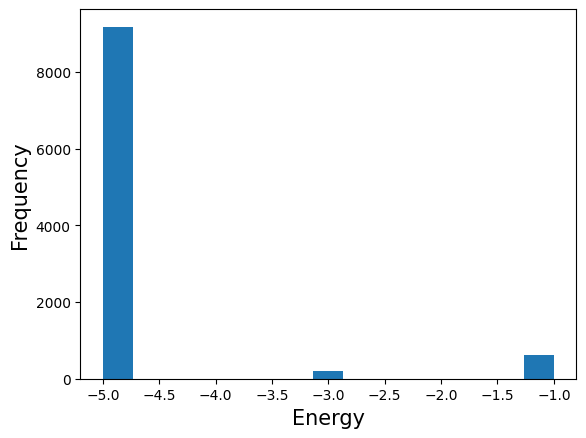

In [3]:
import matplotlib.pyplot as plt

plt.hist(response.energies, bins=15)
plt.xlabel('Energy', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

The solution with energy -5 is the most frequently obtained. As mentioned earlier, this is the exact optimal solution.
Also, the bit sequence at this time is $(q_{1},q_{2},q_{3})=(0,0,1)$, and the corresponding 2D structure is as follows:

<img src="../../../assets/protein_folding_optimal_folding_structure.png" width="300" height="300">

Figure 4: Optimal lattice folding structure. Modified from Figure 3(c) in paper [1]: Alejandro Perdomo-Ortiz, Neil Dickson, Marshall Drew-Brook, Geordie Rose and Alán Aspuru-Guzik, Finding low-energy conformations of lattice protein models by quantum annealing. Sci Rep 2, 571 (2012). https://doi.org/10.1038/srep00571 ([CC-BY 4.0.](https://creativecommons.org/licenses/by/4.0/))

### 4. Comparison of the results of the direct HUBO and the reference paper [1]

Finally, we compare the direct solution by HUBO with the results of the reference paper [1].
Figure 5 below shows the measurement results from paper [1], showing the 2D structure that the protein can take at each energy.
Note that in paper [1], HUBO is converted to QUBO and then solved using D-wave.

<img src="../../../assets/protein_folding_qa_result.png" width="800" height="1000">

Figure 5: Lattice folding structure and energy patterns obtained from the measurements. Modified from Figure 3(c) in paper [1]: Alejandro Perdomo-Ortiz, Neil Dickson, Marshall Drew-Brook, Geordie Rose and Alán Aspuru-Guzik, Finding low-energy conformations of lattice protein models by quantum annealing. Sci Rep 2, 571 (2012). https://doi.org/10.1038/srep00571 ([CC-BY 4.0.](https://creativecommons.org/licenses/by/4.0/))

The blue structure in the figure is the measurement result of Experiment 3 in Scheme 3.

According to Figure 5, a list of energy measurement results from the reference paper [1] is produced below. Note that structures with positive energy values are ignored. According to the paper [1], such structures seemed to be 8% of the total.

In [4]:
import numpy as np

energy_qa = np.zeros(num_reads)
# The energy -5 solution was obtained 4164 times.
energy_qa[:4164] = -5 
# The energy -3 solution was obtained 3717 times.
energy_qa[4164:4164+1317] = -3
# The energy -1 solution was obtained 3719 times for a total of 415, 381, 1371, and 1552 times for the 4-state structure, respectively.
energy_qa[4164+1317:4164+1317+415+381+1371+1552] = -1


A histogram of the results comparing the two is shown below.

Text(0, 0.5, 'Frequency')

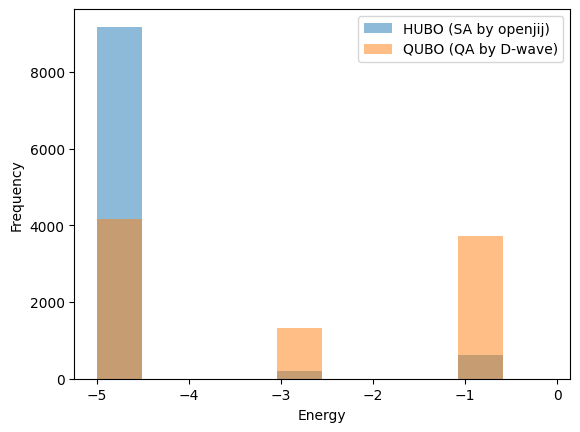

In [5]:
plt.hist(response.energies, label='HUBO (SA by openjij)', range=(-5, -0.1), bins=10, alpha=0.5)
plt.hist(energy_qa, label='QUBO (QA by D-wave)', range=(-5, -0.1), bins=10, alpha=0.5)
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Frequency')

Although a simple comparison cannot be made since they are SA and QA, the results show that the HUBO direct solution method (SA using openjij) yields more energy to derive the optimal solution than the QUBO transformed solution method (QA using D-wave).

## References

1. Alejandro Perdomo-Ortiz, et.al "Finding low-energy conformations of lattice protein models by quantum annealing". Scientific Reports volume 2, Article number: 571 (2012)
2. Dill KA (March 1985). "Theory for the folding and stability of globular proteins". Biochemistry. 24 (6)
3. Miyazawa, S. & Jernigan, R. L. Residue-residue potentials with a favorable contact pair term and an unfavorable high packing density term, for simulation and threading. J. Mol. Biol. 256, 623–644 (1996).